# Проект: Принятие решений в бизнесе

В рамках работы крупного интернет-магазина вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки.

**Задачи:**
- Приоритизировать гипотезы;
- Запустить A/B-тест;
- Проанализировать результаты. 

В нашем распоряжении 3 датафрейма - файл `/datasets/hypothesis.csv` содержит информацию о 9 гипотезах по увеличению выручки интернет-магазина с указанными параметрами `Reach, Impact, Confidence, Effort`, после проведения `A/B-теста` полученные результаты будут описаны в файлах `/datasets/orders.csv` и `/datasets/visitors.csv`.

In [1]:
#импортируем все необходимые библиотеки 
import pandas as pd
import scipy.stats as stats
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters

## Приоритизация гипотез

In [2]:
#для начала импортируем датафрейм с гипотезами для их оценки
hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [3]:
hypothesis.head()
hypothesis.style.set_properties(**{'text-align': 'left'})

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Каждый из параметров `Reach/Impact/Confidence/Efforts` в таблице `hypothesis` оценен по 10-бальной шкале.

**1.1. Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.**

In [4]:
#добавим новый столбец где рассчитаем параметр ICE
hypothesis['ICE'] = round((hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts'], 1)

In [5]:
hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.2
0,"Добавить два новых канала привлечения трафика,...",13.3
7,Добавить форму подписки на все основные страни...,11.2
6,Показать на главной странице баннеры с актуаль...,8.0
2,Добавить блоки рекомендаций товаров на сайт ин...,7.0
1,"Запустить собственную службу доставки, что сок...",2.0
5,"Добавить страницу отзывов клиентов о магазине,...",1.3
3,"Изменить структура категорий, что увеличит кон...",1.1
4,"Изменить цвет фона главной страницы, чтобы уве...",1.0


Согласно методу `ICE` в первую очередь следует проверять гипотезы [8, 0, 7]. 

**1.2. Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.**

In [6]:
#добавим новый столбец где рассчитаем параметр RICE
hypothesis['RICE'] = round((hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts'], 1)

In [7]:
hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


По методу `RICE` в первую очередь следует проверять гипотезы [7, 2, 0].

**1.3. Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.**

In [8]:
hypothesis[['Hypothesis', 'ICE', 'RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,ICE,RICE
7,Добавить форму подписки на все основные страни...,11.2,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,7.0,56.0
0,"Добавить два новых канала привлечения трафика,...",13.3,40.0
6,Показать на главной странице баннеры с актуаль...,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2,16.2
3,"Изменить структура категорий, что увеличит кон...",1.1,9.0
1,"Запустить собственную службу доставки, что сок...",2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",1.0,3.0


Несмотря на то, что параметры `ICE` и `RICE` имеют разные порядки, отсортировав гипотезы видим общие тренды в оценке гипотез (особенно в части гипотез-аутсайдеров). При этом ТОП гипотез по каждому фреймворку разный - согласно `ICE` в первую очередь следует брать в работу гипотезы [8, 0, 7], по `RICE` гипотезы [7, 2, 0], а гипотеза лидер по `ICE` [8] в системе `RICE` занимает 5-е место. 

Оснонвое различие в оценке фреймворков заключается в учете охвата (*Reach*). В нашем случае охват является ключевой характеристикой работы интернет-магазина и будет напрямую влиять на конверсию и конечный результат. Далее при определении гипотез для тестирования следует опираться на приоритезацию по `RICE`.

## Анализ A/B-теста

In [9]:
#импортируем датафреймы с результатами A/B-теста
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [10]:
#форматируем столбец с датой для построения будущих графиков
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [11]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [12]:
#посчитаем долю пропусков в orders по стобцам
orders.isna().mean().to_frame(name="nans").query("nans > 0")["nans"]

Series([], Name: nans, dtype: float64)

In [13]:
#посчитаем долю пропусков в visitors по стобцам 
visitors.isna().mean().to_frame(name="nans").query("nans > 0")["nans"]

Series([], Name: nans, dtype: float64)

In [14]:
#посчитаем долю дубликатов в orders 
orders.duplicated().mean()

0.0

In [15]:
#посчитаем долю дубликатов в visitors  
visitors.duplicated().mean()

0.0

In [16]:
#выведем датафреймы, чтобы ознакомиться со структурой данных
orders.head(), visitors.head()

(   transactionId   visitorId       date  revenue group
 0     3667963787  3312258926 2019-08-15     1650     B
 1     2804400009  3642806036 2019-08-15      730     B
 2     2961555356  4069496402 2019-08-15      400     A
 3     3797467345  1196621759 2019-08-15     9759     B
 4     2282983706  2322279887 2019-08-15     2308     B,
         date group  visitors
 0 2019-08-01     A       719
 1 2019-08-02     A       619
 2 2019-08-03     A       507
 3 2019-08-04     A       717
 4 2019-08-05     A       756)

**2.1. Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.**

In [17]:
#конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [18]:
#задаем размеры всех графиков
plt.rcParams ['figure.figsize'] = [10, 5]

In [19]:
#создадим массив уникальных пар значений дат и групп теста методом 
dates_groups = orders[['date', 'group']].drop_duplicates()
dates_groups

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [20]:
#cоберём агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

In [21]:
orders_aggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [22]:
#получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])
visitors_aggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
496,2019-08-29,B,17708
730,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [23]:
#объединим данные в единую таблицу
cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)

In [24]:
cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [25]:
#соберем данные с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

In [26]:
#соберем данные с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

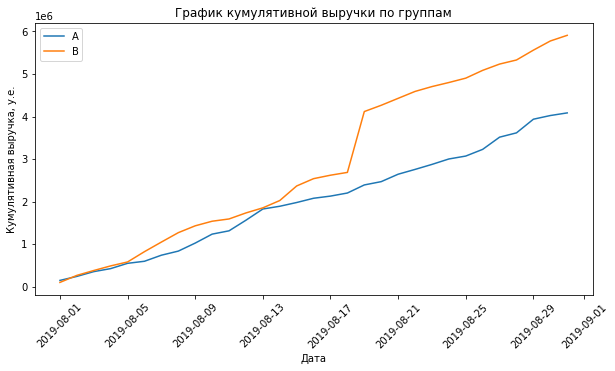

In [27]:
#cтроим график выручки по группам
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка, у.е.')
plt.title('График кумулятивной выручки по группам')
plt.show()

Выручка увеличивается в течение всего теста - в начале теста группа B незначительно опережала группу А (местами выручка в группах сравнивалась). Примерно в середине теста группа B значительно вырвалась вперед - возможно на такой значительный скачок повлияли выбросы в данных, т.е. аномально большие заказы в группе B.

<div class="alert alert-block alert-success">
    
**Комментарий от ревьюера**

Верно, но пока мы не знаем, с чем связан скачок в группе B: с резким увеличением количества заказов или с ростом стоимости.
</div>

**2.2. Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.**

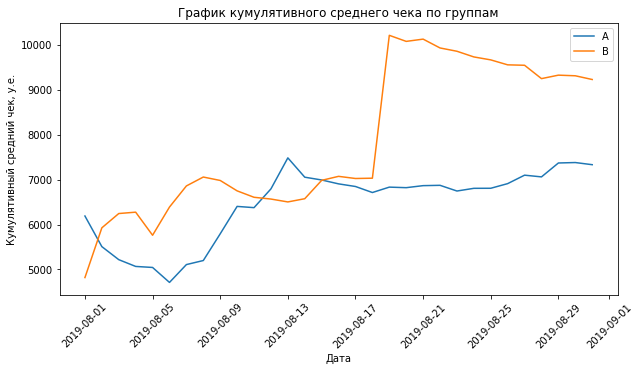

In [28]:
#графики среднего чека по группам получим разделив кумулятивную выручку на кумулятивное число заказов
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/
         cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/
         cumulative_revenue_b['orders'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек, у.е.')
plt.title('График кумулятивного среднего чека по группам')
plt.show()

Куммулятивные значения среднего чека по группам в начале теста были подвержены значительным коллебаниям, к середине теста группа А вышла на плато, а группа В имеет значительный скачок вверх с последующим снижением значений.

**2.3. Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.**

In [29]:
#собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(
    cumulative_revenue_b, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B']
)

In [30]:
merged_cumulative_revenue

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101
5,2019-08-06,598401,127,824337,129
6,2019-08-07,740818,145,1049671,153
7,2019-08-08,837097,161,1270589,180
8,2019-08-09,1025603,177,1431401,205
9,2019-08-10,1236098,193,1539203,228


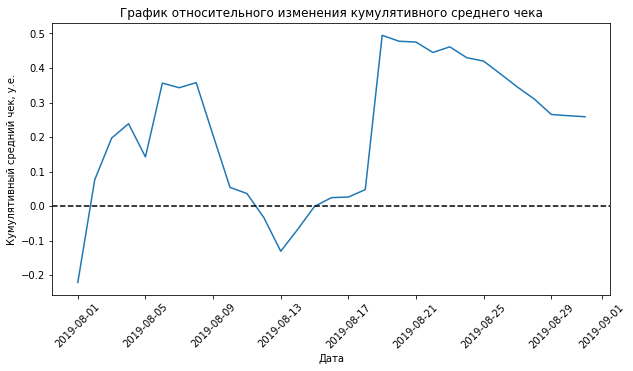

In [31]:
#посмотрим на отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (
    merged_cumulative_revenue['revenueB']/
    merged_cumulative_revenue['ordersB'])/
         (merged_cumulative_revenue['revenueA']/
          merged_cumulative_revenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--') # добавляем ось X
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек, у.е.')
plt.title('График относительного изменения кумулятивного среднего чека')
plt.show()

Значения относительного изменения среднего чека значительно менялись в несколько дат, вероятно тогда и были совершены аномально большие заказы.

**2.4. Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.**

In [32]:
#считаем кумулятивную конверсию (среднее количество заказов)
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

In [33]:
#отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

In [34]:
#отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

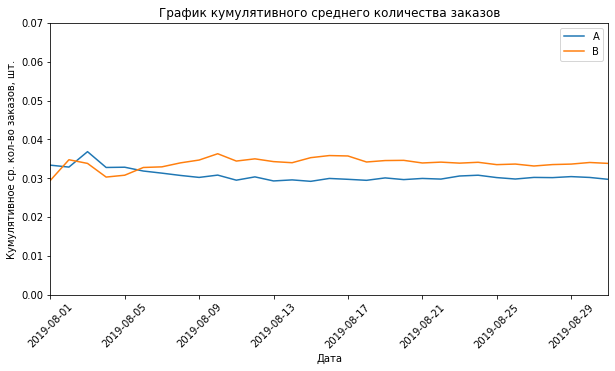

In [35]:
#строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0, 0.07]) # задаем масштаб осей
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Кумулятивное ср. кол-во заказов, шт.')
plt.title('График кумулятивного среднего количества заказов')
plt.show()

Мы задали масштабы осей на графике, чтобы сгладить относительные колебания в течение теста и более наглядно увидеть, что обе группы зафиксирвоались около среднего значения. 

В начале теста обе группы были подвержены колебаниям, местами группа А вырывалась вперед. Ко второй неделе теста обе группы выровнялись и группа В зафиксировалась около значений, стабильно больших, чем у группы А.

**2.5. Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.**

In [36]:
#объединим датафреймы с комулятивными конверсиями по группам
merged_cumulative_conversions = cumulative_data_a[
    ['date','conversion']].merge(cumulative_data_b[['date','conversion']], 
                                 left_on='date', 
                                 right_on='date', 
                                 how='left', 
                                 suffixes=['A', 'B']
                                )

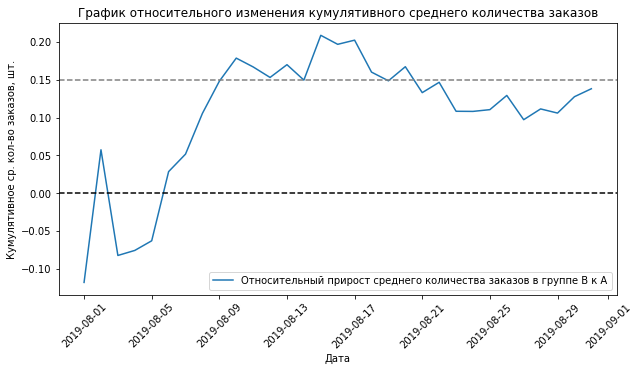

In [37]:
#посмтроим график относительного прироста среднего количества заказов
plt.plot(
    merged_cumulative_conversions['date'], 
    merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA'] - 1, 
    label="Относительный прирост среднего количества заказов в группе B к A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Кумулятивное ср. кол-во заказов, шт.')
plt.title('График относительного изменения кумулятивного среднего количества заказов')
plt.show()

Со второй недели теста группа B имеет большее среднее количество заказов, чем в группе А, в среднем на 10-20%.

**2.6. Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.**

In [38]:
#посчитаем количество заказов по пользователям
orders_by_users = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

In [39]:
orders_by_users.columns = ['visitorId', 'orders']

In [40]:
#серия из чисел от 0 до количества наблюдений в orders_by_users
x_values = pd.Series(range(0,len(orders_by_users))) 

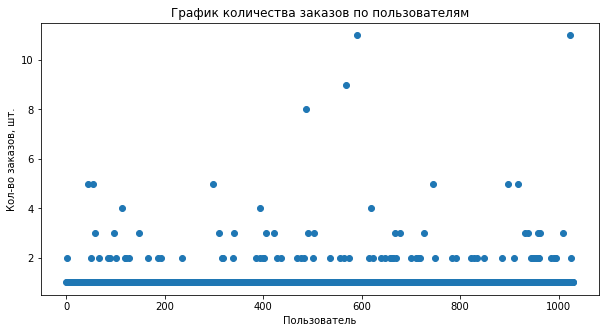

In [41]:
#строим график
plt.scatter(x_values, orders_by_users['orders'])
plt.xlabel('Пользователь')
plt.ylabel('Кол-во заказов, шт.')
plt.title('График количества заказов по пользователям')
plt.show()

Большинство значений установились на отметке 2-х заказов, наблюдаются значительные выбросы на отметках 3-5 заказов, и единичные выбросы на более высоких значениях.

**2.7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.**

In [42]:
#c помощью встроенной функции Numpy найдем 95-й и 99-й перцентили
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

In [43]:
#сохраним среднее значение перцентелей в переменную для дальнейших расчетов
orders_percentile = np.percentile(orders_by_users['orders'], [95, 99]).mean()

In [44]:
orders_percentile

3.0

Не более 5%  пользователей совершали больше 2-х заказов, и не более 1% пользователей совершил больше 4-х заказов. Примем за границу выбросов усредненное значение 3, все что выше этого будем отсекать.

**2.8. Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.**

In [45]:
x_values = pd.Series(range(0, len(orders['revenue'])))

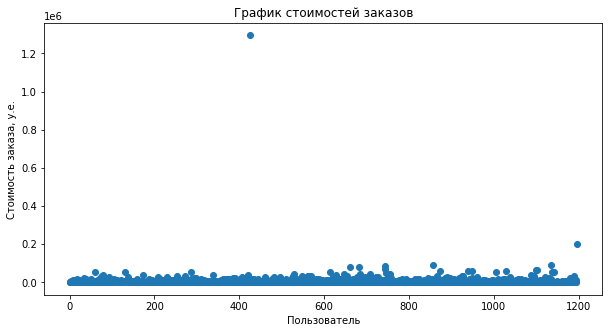

In [46]:
plt.scatter(x_values, orders['revenue']) 
plt.xlabel('Пользователь')
plt.ylabel('Стоимость заказа, у.е.')
plt.title('График стоимостей заказов')
plt.show()

Основная масса значений установилась до отметки в 100000. Наблюдается несколько единичных выбросов на отметках 200000 и 1200000. 

**2.9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.**

In [47]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

In [48]:
revenue_percentile = np.percentile(orders['revenue'], [95, 99]).mean()

In [49]:
revenue_percentile

43116.6

Не более 5%  пользователей сделали заказ на сумму более 28000, и не более 1% пользователей сделали заказ дороже 58000. Примем за границу выбросов стоимость заказа усредненную величину около 43000, все что выше этой суммы будем отсекать.

**2.10. Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.**

Лучше всего в данном случае для проверки статистической значимости различий в среднем количестве заказов (и в дальнейшем в среднем чеке заказов) подойдет непараметрический тест по `критерию Манна-Уитни`. Он поможет более точно сделать выводы на основе наших выборок, ведь он не так чувствителен к данным с большими (по сравнению с нормальным распределением) выбросами, чем параметрические тесты.

Гипотезы для следующего теста сформулируем следующим образом:

`H_0: Cтатистически значимых различий в среднем количестве заказов между группами по «сырым» данным нет`
<br>
`H_1: Cтатистически значимые различия в среднем количестве заказов между группами по «сырым» данным  есть`

Значение `alpha` примем = `.05`

In [50]:
alpha = .05

In [51]:
#посчитаем количество пользователей по датам в группе А
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]

In [52]:
visitors_a_daily.columns = ['date', 'visitorsPerDateA']

In [53]:
#посчитаем количество пользователей по датам в группе В
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]

In [54]:
visitors_b_daily.columns = ['date', 'visitorsPerDateB']

In [55]:
#посчитаем количество заказов по датам в группе А
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)

In [56]:
orders_a_daily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [57]:
#посчитаем количество заказов по датам в группе В
orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)

In [58]:
orders_b_daily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [59]:
#посчитаем количество заказов на пользователя в группе А
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

In [60]:
orders_by_users_a.columns = ['visitorId', 'orders']

In [61]:
#посчитаем количество заказов на пользователя в группе В
orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

In [62]:
orders_by_users_b.columns = ['visitorId', 'orders'] 

Объявим переменные `sample_b` и `sample_b`, в которых пользователям из разных групп будет соответствовать количество заказов - 

In [63]:
sample_a = pd.concat(
    [orders_by_users_a['orders'],
     pd.Series(0, 
               index=np.arange(
                   visitors_a_daily['visitorsPerDateA'].sum() - len(orders_by_users_a['orders'])), 
               name='orders')],
    axis=0
)

In [64]:
sample_b = pd.concat(
    [orders_by_users_b['orders'],
     pd.Series(0, 
               index=np.arange(
                   visitors_b_daily['visitorsPerDateB'].sum() - len(orders_by_users_b['orders'])), 
               name='orders')],
    axis=0
)

Проверим наши выборки критерием Манна-Уитни.

In [65]:
#зафиксируем результаты
raw_orders_mannwhitneyu = stats.mannwhitneyu(sample_a, sample_b)[1]

raw_orders_delta = sample_b.mean() / sample_a.mean() - 1

display(f"p-value = {round(raw_orders_mannwhitneyu, 5)}")

if raw_orders_mannwhitneyu < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
display(f"Относительный прирост среднего количества заказов группы В к группе А составляет {round(raw_orders_delta, 3)}")

'p-value = 0.01679'

Отвергаем нулевую гипотезу


'Относительный прирост среднего количества заказов группы В к группе А составляет 0.138'

P-value ниже 0.05, поэтому нулевую гипотезу можем отвергнуть. Расчеты по сырым данным показывают, что между группами есть статистически значимые различия в среднем количестве заказов, а относительный прирост среднего количества заказов группы В к группе А составляет 13,8 %.

**2.11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.**

Гипотезы для дальнейшего расчета:

`H_0: Cтатистически значимых различий в среднем чеке заказа между группами по «сырым» данным нет`
<br>
`H_1: Cтатистически значимые различия в среднем чеке заказа между группами по «сырым» данным есть`

Значение `alpha` примем = `.05`

In [66]:
orders[orders['group']=='A']['revenue']

2         400
7        1044
8       13710
10       4008
12       7370
        ...  
1187      750
1188      112
1193     3190
1194    10550
1195      100
Name: revenue, Length: 557, dtype: int64

In [67]:
#проверим значимость различий в среднем чеке критерием Манна-Уитни
raw_revenue_mannwhitneyu = stats.mannwhitneyu(
        orders[orders['group']=='A']['revenue'], 
        orders[orders['group']=='B']['revenue'])[1]

raw_revenue_delta = orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1

display(f"p-value = {round(raw_revenue_mannwhitneyu, 5)}")

if raw_revenue_mannwhitneyu < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
display(f"Относительное различие среднего чека группы В к группе А составляет {round(raw_revenue_delta, 3)}")

'p-value = 0.72929'

Не получилось отвергнуть нулевую гипотезу


'Относительное различие среднего чека группы В к группе А составляет 0.259'

P-value значительно выше 0.05, значит статистически значимых отличий в среднем чеке между группами по сырым данным нет. При этом относительное различие среднего чека между группами составляет больше 25%. Скорее всего причина такого сильно различия кроется в выбросах.

**2.12. Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.**

Приступаем к подготовке очищенных от аномалий данных.

Примем за аномальных пользователей тех, кто совершил 4 заказа и более, или совершил заказ на сумму свыше около 43 000 рублей. Так мы уберем от 1% до 5% пользователей с наибольшим числом заказов и заказов с наибольшей стоимостью.

In [68]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > orders_percentile]['visitorId'],
        orders_by_users_b[orders_by_users_b['orders'] > orders_percentile]['visitorId'],
    ],
    axis=0,
)

In [69]:
users_with_expensive_orders = orders[orders['revenue'] > revenue_percentile]['visitorId']

In [70]:
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [71]:
abnormal_users.head(5)

1099    148427295
18      199603092
23      237748145
648     382846391
1137    759473111
Name: visitorId, dtype: int64

Гипотезы для дальнейшего проведения теста:

`H_0: Cтатистически значимых различий в среднем количестве заказов между группами по «очищенным» данным нет`
<br>
`H_1: Cтатистически значимые различия в среднем количестве заказов между группами по «очищенным» данным  есть`

Значение `alpha` примем = `.05`

In [72]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitorId'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_a_daily['visitorsPerDateA'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
sample_a_filtered

0        1
1        1
2        1
3        1
4        1
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: orders, Length: 18712, dtype: int64

In [73]:
sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitorId'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_b_daily['visitorsPerDateB'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [74]:
orders_mannwhitneyu = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]

orders_delta = sample_b_filtered.mean() / sample_a_filtered.mean() - 1

display(f"p-value = {round(orders_mannwhitneyu, 5)}")

if orders_mannwhitneyu < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
display(f"Относительное различие среднего чека группы В к группе А составляет {round(orders_delta, 3)}")

'p-value = 0.00862'

Отвергаем нулевую гипотезу


'Относительное различие среднего чека группы В к группе А составляет 0.165'

Как и в случае с сырыми данными, статистическая значимость достигнута (p-value ниже 0,05), а группа В показывает результат по среднему количеству заказов на 16.5% выше, чем группа А. В целом этот результат сравним с результатом по неочищенным данным.

**2.13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.**

Гипотезы для дальнейшего расчета:

`H_0: Cтатистически значимых различий в среднем чеке заказа между группами по «очищенным» данным нет`
<br>
`H_1: Cтатистически значимые различия в среднем чеке заказа между группами по «очищенным» данным есть`

Значение `alpha` примем = `.05`

In [75]:
#проверим значимость различий в среднем чеке критерием Манна-Уитни
revenue_mannwhitneyu = stats.mannwhitneyu(
        orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormal_users)),
            )
        ]['revenue'],
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormal_users)),
            )
        ]['revenue'],
    )[1]

revenue_delta = (orders[
        np.logical_and(
            orders['group'] == 'B',
            np.logical_not(orders['visitorId'].isin(abnormal_users)),
        )
    ]['revenue'].mean()
    / orders[
        np.logical_and(
            orders['group'] == 'A',
            np.logical_not(orders['visitorId'].isin(abnormal_users)),
        )
    ]['revenue'].mean()
    - 1)

display(f"p-value = {round(revenue_mannwhitneyu, 5)}")

if revenue_mannwhitneyu < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
display(f"Относительное различие среднего чека группы В к группе А составляет {round(revenue_delta, 3)}")

'p-value = 0.68303'

Не получилось отвергнуть нулевую гипотезу


'Относительное различие среднего чека группы В к группе А составляет 0.067'

P-value = `0.683`, значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке заказа (по "очищенным" данным) между группами нет, не отвергаем. При этом разница в среднем чеке между группами по очищенным данным почти в `5 раз` ниже и составляет всего 6,7%, значит выбросы в данных оказывали значительное влияние на результаты.

**2.14. Примите решение по результатам теста и объясните его.**

Промежуточные выводы: 
- график среднего количества заказов по группам показывает, что обе группы вышли на плато;
- статистическая значимость различий в среднем чеке заказа между группами (как по "очищенным", так и по "сырым" данным) отсутствует, а разница в среднем чеке составляет 6,7%;
- зафиксирована статистическая значимость различий в среднем количестве заказов на посетителя между группами (как по "очищенным", так и по "сырым" данным, а разница в среднем количестве заказов на посетителя составляет 16,5% в пользу группы В.

С учетом вышесказанного `можем остановить тест и зафиксировать победу группы В`.

## Выводы

Исходя из расчетов статистической значимости различий в среднем количестве заказов на посетителя и среднем чеке, а также анализе графиков соответствующих графиков:

- В данных присутствовали аномалии, оказавшие значительное влияние на расчет метрик среднего чека;
- Есть статистически значимое различие по среднему количеству заказов между группами как по «сырым», так и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения;

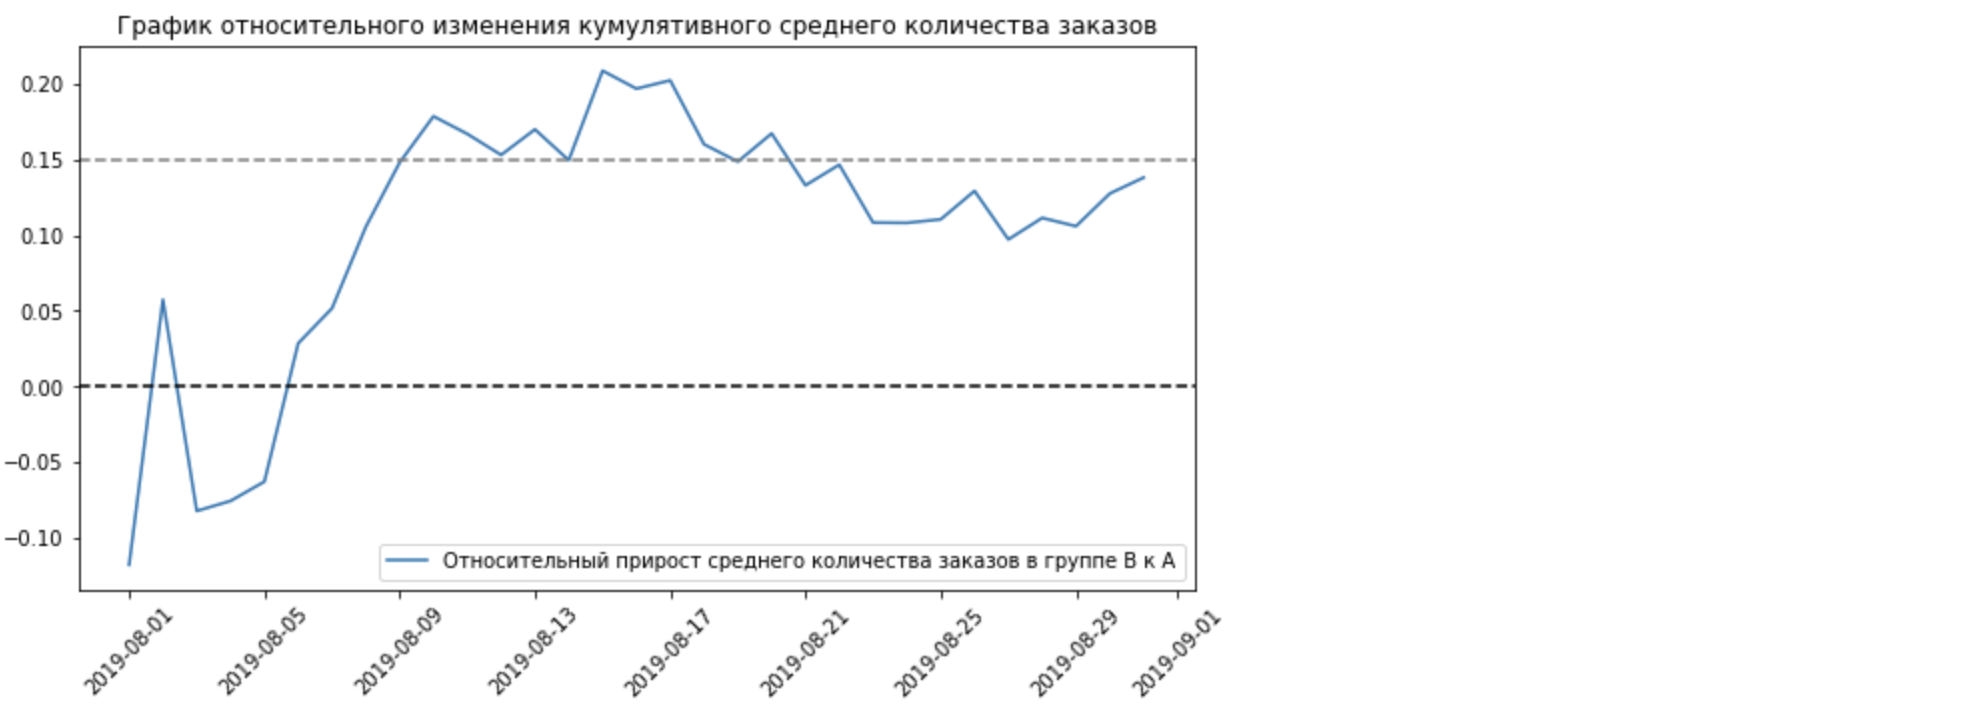

- График различия среднего чека колеблется, сделать из этого графика определённые выводы нельзя, однозначно последнюю неделю теста результаты группы B ухудшаются день ото дня.

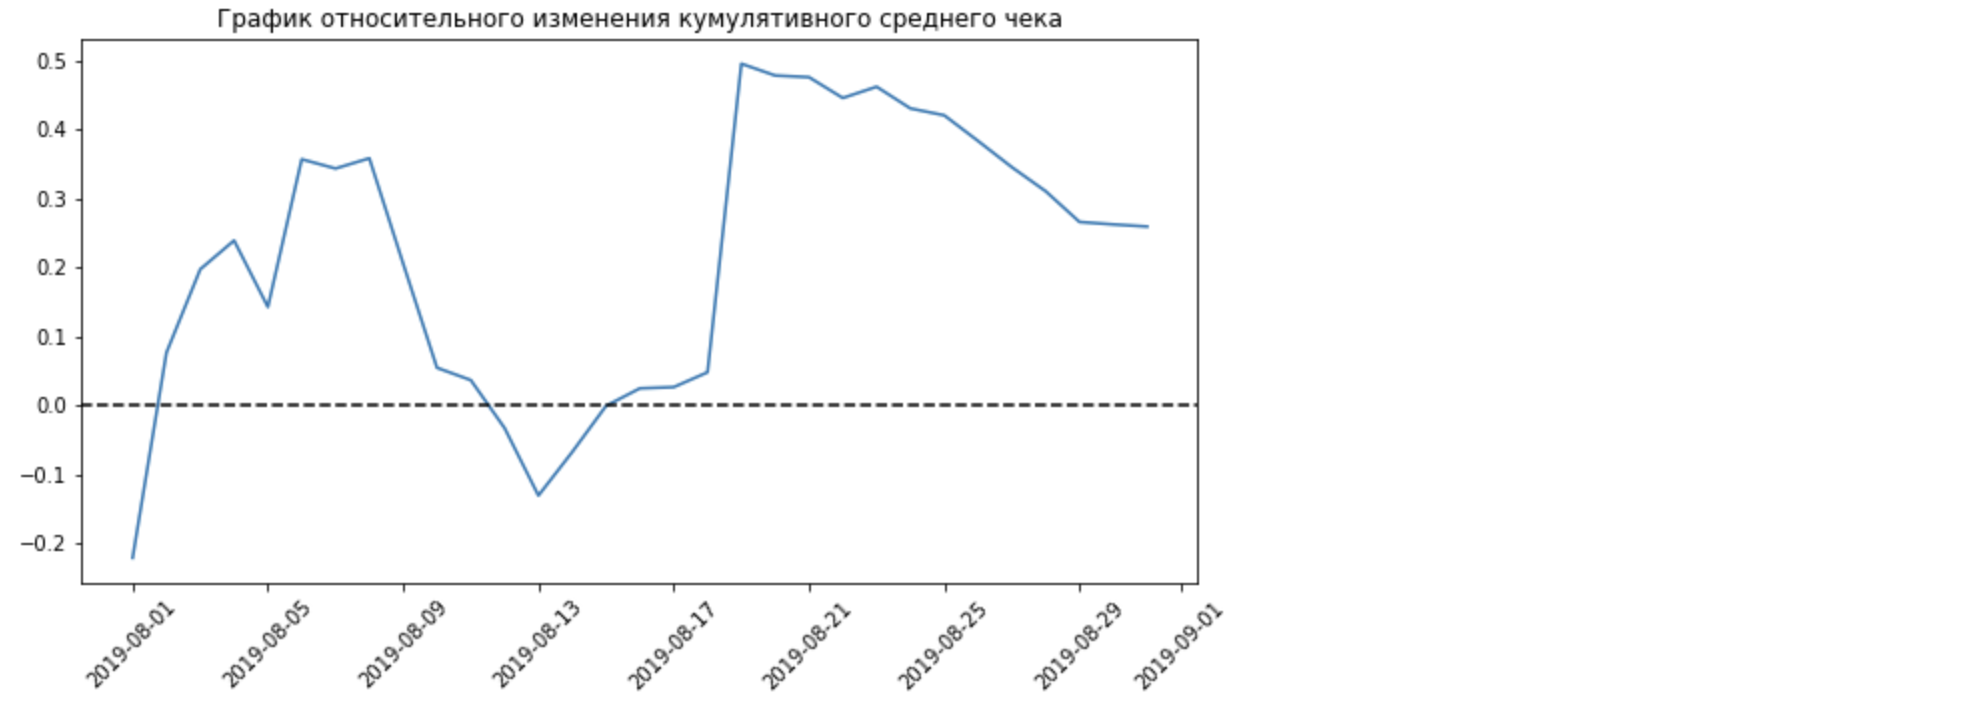

Получается, `среднее количество заказов в группе В лучше, чем в группе А`, но средний чек пользователей обеих групп условно равнозначен. Значит, гипотеза, которую мы тестировали, влияет на среднее количество заказов, но не оказывает влияния на средний чек заказа.

Сам факт увеличения среднего количества заказов (и фиксации этой величины на определенном уровне) позволяет нам принять решение `остановить тест, и зафиксировать победу группы B`.